# General cleaning of Terry_Stops.csv

In [1]:
# import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import RFE
import seaborn as sns
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
%matplotlib inline

### Information about the dataset
"In Terry v. Ohio (Links to an external site.), a landmark Supreme Court case in 1967-8, the court found that a police officer was not in violation of the "unreasonable search and seizure" clause of the Fourth Amendment, even though he stopped and frisked a couple of suspects only because their behavior was suspicious. Thus was born the notion of "reasonable suspicion", according to which an agent of the police may e.g. temporarily detain a person, even in the absence of clearer evidence that would be required for full-blown arrests etc. Terry Stops are stops made of suspicious drivers."

Build a classifier to predict whether an arrest was made after a Terry Stop, given information about the presence of weapons, the time of day of the call, etc. Note that this is a binary classification problem.

***
## Import dataframe from csv file using pd.read_csv function

In [2]:
#importing cvs file and saving it under a variable
terry_df = pd.read_csv('../data/Terry_Stops.csv')

***
## Review kc_house_data

In [3]:
terry_df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001463,28806,Field Contact,None,5670,1965,M,White,...,07:59:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000001516,29599,Field Contact,None,4844,1961,M,White,...,19:12:00,-,-,-,NaN,N,-,-,-,-
3,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
4,-,-1,20150000001739,33155,Field Contact,None,6973,1977,M,White,...,00:41:00,-,-,-,NaN,N,N,-,-,-


In [4]:
terry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44869 entries, 0 to 44868
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         44869 non-null  object
 1   Subject ID                44869 non-null  int64 
 2   GO / SC Num               44869 non-null  int64 
 3   Terry Stop ID             44869 non-null  int64 
 4   Stop Resolution           44869 non-null  object
 5   Weapon Type               44869 non-null  object
 6   Officer ID                44869 non-null  object
 7   Officer YOB               44869 non-null  int64 
 8   Officer Gender            44869 non-null  object
 9   Officer Race              44869 non-null  object
 10  Subject Perceived Race    44869 non-null  object
 11  Subject Perceived Gender  44869 non-null  object
 12  Reported Date             44869 non-null  object
 13  Reported Time             44869 non-null  object
 14  Initial Call Type     

In [5]:
terry_df.shape

(44869, 23)

In [6]:
terry_df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat'],
      dtype='object')

***
##  Creating subset dataframe with columns to be used

In [7]:
terry_df = terry_df[['Subject Age Group', 'Subject ID', 'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB', 'Officer Gender', 'Officer Race', 'Subject Perceived Race', 'Subject Perceived Gender', 'Reported Date', 'Initial Call Type', 'Call Type', 'Officer Squad', 'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat' ]]

In [8]:
# renaming columns
terry_df.columns = ['subject_age', 'subject_id', 'stop_resolution',
         'weapon_type', 'officer_id', 'officer_age', 
         'officer_gender', 'officer_race', 'subject_race', 
         'subject_gender', 'date', 'initial_call_type', 'call_type',
         'officer_squad', 'arrest', 'frisk',
         'precinct', 'sector', 'beat' ]

In [9]:
terry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44869 entries, 0 to 44868
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_age        44869 non-null  object
 1   subject_id         44869 non-null  int64 
 2   stop_resolution    44869 non-null  object
 3   weapon_type        44869 non-null  object
 4   officer_id         44869 non-null  object
 5   officer_age        44869 non-null  int64 
 6   officer_gender     44869 non-null  object
 7   officer_race       44869 non-null  object
 8   subject_race       44869 non-null  object
 9   subject_gender     44869 non-null  object
 10  date               44869 non-null  object
 11  initial_call_type  44869 non-null  object
 12  call_type          44869 non-null  object
 13  officer_squad      44288 non-null  object
 14  arrest             44869 non-null  object
 15  frisk              44869 non-null  object
 16  precinct           44869 non-null  objec

***
## Converting column datatypes

In [10]:
# changing columns into categories and datetime
terry_df = terry_df.astype({'subject_age': 'category', 'officer_gender':'category', 
                'officer_race': 'category', 'subject_race':'category', 
                'subject_gender':'category', 'date':'datetime64','arrest':'category', 
                'frisk':'category','precinct':'category', 'sector':'category',
                'beat': 'category'})

In [11]:
terry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44869 entries, 0 to 44868
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   subject_age        44869 non-null  category      
 1   subject_id         44869 non-null  int64         
 2   stop_resolution    44869 non-null  object        
 3   weapon_type        44869 non-null  object        
 4   officer_id         44869 non-null  object        
 5   officer_age        44869 non-null  int64         
 6   officer_gender     44869 non-null  category      
 7   officer_race       44869 non-null  category      
 8   subject_race       44869 non-null  category      
 9   subject_gender     44869 non-null  category      
 10  date               44869 non-null  datetime64[ns]
 11  initial_call_type  44869 non-null  object        
 12  call_type          44869 non-null  object        
 13  officer_squad      44288 non-null  object        
 14  arrest

***
## Exploring column value counts and dealing with nan values

In [12]:
# the dataset seems to have '-' as place holders
# replacing '-' into Nan
terry_df.replace('-', np.nan, inplace=True)

In [13]:
terry_df.isna().sum()

subject_age           1420
subject_id               0
stop_resolution          0
weapon_type           9700
officer_id              24
officer_age              0
officer_gender           0
officer_race             0
subject_race          1764
subject_gender         266
date                     0
initial_call_type    13039
call_type            13039
officer_squad          581
arrest                   0
frisk                  478
precinct              9733
sector                9931
beat                  9878
dtype: int64

In [14]:
terry_df.mode()

,subject_age,subject_id,stop_resolution,weapon_type,officer_id,officer_age,officer_gender,officer_race,subject_race,subject_gender,date,initial_call_type,call_type,officer_squad,arrest,frisk,precinct,sector,beat
0,26 - 35,-1,Field Contact,None,7456,1986,M,White,White,Male,2015-10-01,SUSPICIOUS STOP - OFFICER INITIATED ONVIEW,911,TRAINING - FIELD TRAINING SQUAD,N,N,West,E,N3


In [15]:
# found the modes of the df columns so I can replace nan values with mode values
terry_df['subject_race'] = terry_df['subject_race'].fillna('Other')

In [16]:
terry_df['subject_race'].value_counts()

White                                        21930
Black or African American                    13372
Unknown                                       2382
Other                                         1916
Hispanic                                      1684
Asian                                         1431
American Indian or Alaska Native              1303
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander       42
Name: subject_race, dtype: int64

In [17]:
terry_df['subject_age'] = terry_df['subject_age'].fillna('26 - 35')

In [18]:
terry_df['subject_age'].value_counts()

26 - 35         16337
36 - 45          9464
18 - 25          9084
46 - 55          5771
56 and Above     2278
1 - 17           1935
Name: subject_age, dtype: int64

In [19]:
terry_df['subject_gender'] = terry_df['subject_gender'].replace('Unable to Determine',
                                                                'Gender Diverse (gender non-conforming and/or transgender)').replace('Unknown', 'Gender Diverse (gender non-conforming and/or transgender)')


In [20]:
terry_df['subject_gender'] = terry_df['subject_gender'].fillna('Male')

In [21]:
terry_df['subject_gender'].value_counts(dropna=False)

Male                                                 35349
Female                                                9170
Gender Diverse (gender non-conforming and/or t...      350
Name: subject_gender, dtype: int64

In [22]:
terry_df['subject_race'] = terry_df['subject_race'].fillna('Other')

In [23]:
terry_df['subject_race'].value_counts(dropna=False)

White                                        21930
Black or African American                    13372
Unknown                                       2382
Other                                         1916
Hispanic                                      1684
Asian                                         1431
American Indian or Alaska Native              1303
Multi-Racial                                   809
Native Hawaiian or Other Pacific Islander       42
Name: subject_race, dtype: int64

In [24]:
# replace N values in officer gender with mode
terry_df['officer_gender'] = terry_df['officer_gender'].replace('N', 'M')

In [25]:
terry_df['officer_gender'].value_counts(dropna=False)

M    39763
F     5106
Name: officer_gender, dtype: int64

In [26]:
terry_df.isna().sum()

subject_age              0
subject_id               0
stop_resolution          0
weapon_type           9700
officer_id              24
officer_age              0
officer_gender           0
officer_race             0
subject_race             0
subject_gender           0
date                     0
initial_call_type    13039
call_type            13039
officer_squad          581
arrest                   0
frisk                  478
precinct              9733
sector                9931
beat                  9878
dtype: int64

In [27]:
# subtract officier YOB from report date column to get officers age
terry_df['officer_age'] = (terry_df.date.dt.year -  terry_df.officer_age)

In [28]:
terry_df[terry_df.officer_age >70].head()

,subject_age,subject_id,stop_resolution,weapon_type,officer_id,officer_age,officer_gender,officer_race,subject_race,subject_gender,date,initial_call_type,call_type,officer_squad,arrest,frisk,precinct,sector,beat
1068,26 - 35,-1,Field Contact,NaN,NaN,119,M,Unknown,Other,Male,2019-07-27,NaN,NaN,NaN,N,Y,West,K,K3
1069,26 - 35,-1,Field Contact,NaN,NaN,119,M,Unknown,Other,Male,2019-07-27,NaN,NaN,NaN,N,Y,West,K,K3
1070,26 - 35,-1,Field Contact,NaN,NaN,119,M,Unknown,Other,Male,2019-07-27,NaN,NaN,NaN,N,Y,West,K,K3
1091,26 - 35,-1,Field Contact,NaN,NaN,119,M,Unknown,White,Male,2019-09-10,NaN,NaN,NaN,N,N,East,E,E3
1201,26 - 35,-1,Field Contact,NaN,8742,120,M,Unknown,Other,Male,2020-10-17,DOWN - CHECK FOR PERSON DOWN,911,TRAINING - FIELD TRAINING SQUAD,N,N,West,K,K3


In [29]:
# dropping rows that show officers over the 100 y.o.
# these rows ahve a lot of nan or unknown values
terry_df = terry_df.drop(terry_df[terry_df.officer_age >70].index)

In [30]:
terry_df.officer_age.describe()

count    44809.000000
mean        34.658685
std          8.462094
min         21.000000
25%         28.000000
50%         33.000000
75%         39.000000
max         70.000000
Name: officer_age, dtype: float64

In [31]:
# 'not specified' and 'unknown' are the same thing
# so i will just put the values in one column
terry_df.replace({'officer_race' : {'Unknown': 'Not Specified'}})

,subject_age,subject_id,stop_resolution,weapon_type,officer_id,officer_age,officer_gender,officer_race,subject_race,subject_gender,date,initial_call_type,call_type,officer_squad,arrest,frisk,precinct,sector,beat
0,26 - 35,-1,Arrest,None,7500,31,M,Black or African American,Asian,Male,2015-10-16,NaN,NaN,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,26 - 35,-1,Field Contact,None,5670,50,M,White,Other,Male,2015-03-19,NaN,NaN,NaN,N,N,NaN,NaN,NaN
2,26 - 35,-1,Field Contact,None,4844,54,M,White,White,Male,2015-03-21,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN
3,26 - 35,-1,Field Contact,None,7539,52,M,White,Other,Male,2015-04-01,NaN,NaN,NaN,N,N,NaN,NaN,NaN
4,26 - 35,-1,Field Contact,None,6973,38,M,White,Black or African American,Male,2015-04-03,NaN,NaN,NaN,N,N,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44864,56 and Above,16143289890,Field Contact,NaN,8709,23,F,White,White,Male,2020-10-18,TRESPASS,911,TRAINING - FIELD TRAINING SQUAD,N,N,West,M,M2
44865,56 and Above,16168302851,Field Contact,NaN,8724,24,M,White,Other,Male,2020-10-19,"DISTURBANCE, MISCELLANEOUS/OTHER",911,WEST PCT 3RD W - MARY,N,N,West,M,M1
44866,56 and Above,16177694220,Field Contact,NaN,8709,23,F,White,White,Male,2020-10-19,FIGHT - IP - PHYSICAL (NO WEAPONS),ONVIEW,TRAINING - FIELD TRAINING SQUAD,N,N,West,K,K2
44867,56 and Above,16193936552,Field Contact,NaN,8464,31,M,White,White,Male,2020-10-19,DUI - DRIVING UNDER INFLUENCE,"TELEPHONE OTHER, NOT 911",EAST PCT 3RD W - CHARLIE,N,N,East,E,E2


In [32]:
terry_df.officer_race.value_counts(dropna=False)

White                            34132
Hispanic or Latino                2549
Two or More Races                 2489
Asian                             1854
Black or African American         1793
Not Specified                     1244
Nat Hawaiian/Oth Pac Islander      437
American Indian/Alaska Native      311
Unknown                              0
Name: officer_race, dtype: int64

In [33]:
# replace string values with binary values
fa = {'frisk' : {'Y' : 1, 'N' : 0}, 
      'arrest' : {'Y' : 1, 'N' : 0}}

terry_df.replace(fa, inplace=True)

In [34]:
terry_df.arrest.value_counts(dropna=False)

0    42169
1     2640
Name: arrest, dtype: int64

In [35]:
terry_df.frisk.value_counts(dropna=False)

0.0    34356
1.0     9975
NaN      478
Name: frisk, dtype: int64

In [36]:
terry_df = terry_df.dropna(subset=['frisk'])

In [37]:
terry_df.frisk.value_counts(dropna=False)

0.0    34356
1.0     9975
Name: frisk, dtype: int64

In [38]:
terry_df.shape

(44331, 19)

In [39]:
# most of the columsn still have nan values
# however, i will not use most of these columns
# so I will keep them there so that i am not deleting necessary information
# I will rearrage the columns in a format i prefer and then save this to a csv file

terry_df = terry_df[['date','subject_id','subject_age','subject_race','subject_gender',
              'stop_resolution','weapon_type','officer_id','officer_age', 'officer_race', 'officer_gender',
            'officer_squad','initial_call_type','call_type','arrest', 'frisk','precinct', 'sector', 'beat']]

In [44]:
# there are still a lot of Nan values in the data, however
# i do not want to remove/replace data thatmihgt be important
# also i do not plan on using a majority of the data that contains NaN values
terry_df.isna().sum()

date                     0
subject_id               0
subject_age              0
subject_race             0
subject_gender           0
stop_resolution          0
weapon_type           9644
officer_id               0
officer_age              0
officer_race             0
officer_gender           0
officer_squad          535
initial_call_type    12813
call_type            12813
arrest                   0
frisk                    0
precinct              9590
sector                9784
beat                  9731
dtype: int64

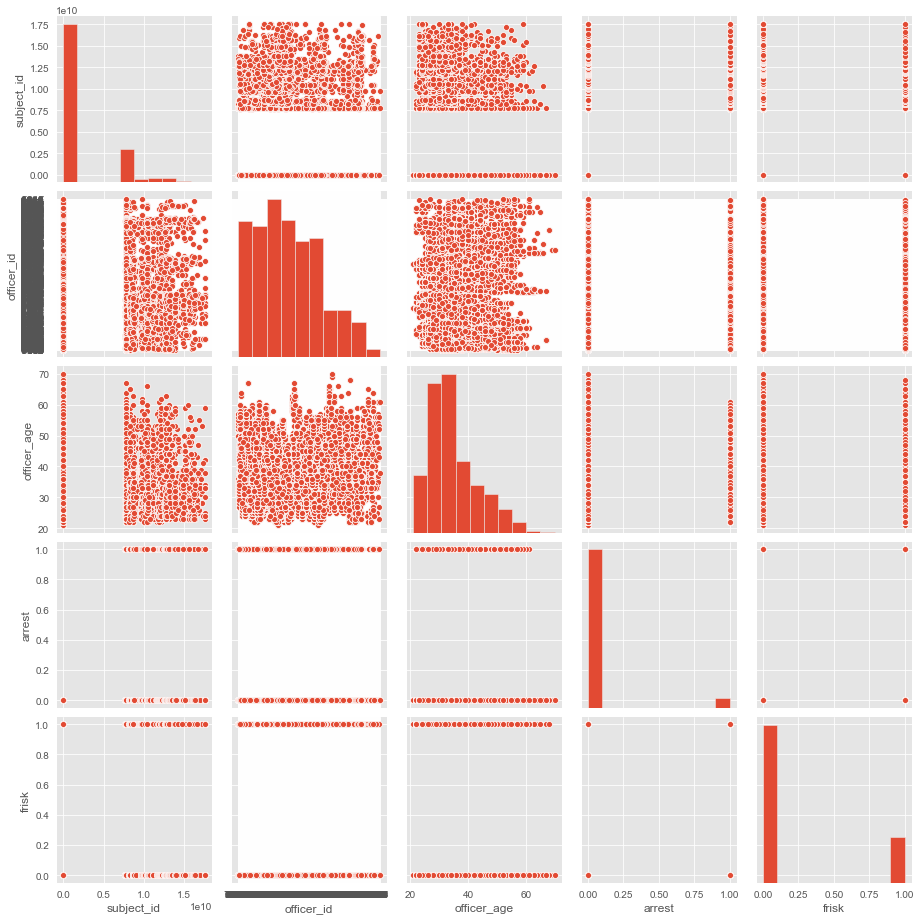

In [45]:
sns.pairplot(terry_df)

In [46]:
terry_df.corr()

,subject_id,officer_age,arrest,frisk
subject_id,1.000000,-0.096329,0.440041,0.032966
officer_age,-0.096329,1.000000,-0.058811,-0.019276
arrest,0.440041,-0.058811,1.000000,0.056144
frisk,0.032966,-0.019276,0.056144,1.000000


<AxesSubplot:>

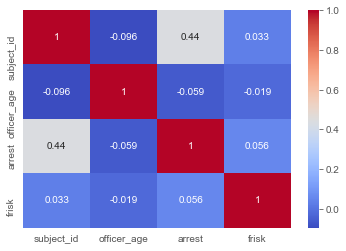

In [47]:
sns.heatmap(terry_df.corr(), annot=True, cmap = 'coolwarm')

In [48]:
terry_df.to_csv('terry_clean.csv', index=False)